![image.png](https://i.imgur.com/a3uAqnb.png)

# **🐱🐶 Cats & Dogs Classification with Pretrained Model (EfficientNet)**

Building on **Day2_1** where we created custom datasets, we now apply those skills to:
- Load a **CSV-based** dataset (different from folder-based in Day2_1)
- Use **Transfer Learning** with a pretrained model instead of training from scratch
- Understand **fine-tuning** for binary classification

In this lab, we will:

✅ Build a **custom Dataset class** for the **Cats & Dogs dataset**  
✅ Use a **pretrained EfficientNet-B0 model** for classification  
✅ Train and evaluate the model  

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import kagglehub
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
# # Please uncomment this out when you are running this lab on google colab!
# import os

# # Set KaggleHub cache to a directory inside /content/
# os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [5]:
# Download the dataset
path = kagglehub.dataset_download("marquis03/cats-and-dogs")
path

Using Colab cache for faster access to the 'cats-and-dogs' dataset.


'/kaggle/input/cats-and-dogs'

## 1️⃣ Dataset Class

In [6]:
class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        
        csv_file = os.path.join(root_dir, f'{split}.csv')
        self.data = pd.read_csv(csv_file)
        
        # Extract image paths and labels from the csv files provided in the dataset
        self.image_paths = self.data['image:FILE'].values
        self.labels = self.data['category'].values
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Construct full image path
        img_path = os.path.join(self.root_dir, self.image_paths[idx])
        
        # Read image
        image = Image.open(img_path).convert('RGB')
        label = float(self.labels[idx])  # BCEWithLogitsLoss expects float, not int
        
        # Apply transforms if any
        if self.transform:
            image = self.transform(image)
            
        return image, label

### **🔍 Key Differences from Day2_1:**
- Labels come from **CSV file** instead of folder names
- Using `float(self.labels[idx])` because `BCEWithLogitsLoss` expects float, not int
- `.convert('RGB')` ensures all images have 3 channels (some may be grayscale)

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Flip images randomly
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                          std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Create dataset objects
train_dataset = CatsDogsDataset(path, split='train', transform=transform)
valid_dataset = CatsDogsDataset(path, split='val', transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check a batch of images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.],
       dtype=torch.float64)


### **📊 Why These Specific Normalization Values?**
#### In the transformation pipeline, we use **specific mean and standard deviation values**

```python
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
```

✅ These are **ImageNet statistics** - the dataset EfficientNet was pretrained on  
✅ When using pretrained models, **always use the same normalization** they were trained with  
✅ Mismatch = poor performance!  



-
**Why?**

1️⃣ **Pretrained Models Expect These Values**  
   - If a model was trained using a certain mean & std, we should use the **same values** for inference/training.
   - This ensures the input distribution matches what the model was trained on.
   - We are fintuning an EfficientNet here, which was pretrained on Imagenet, so will use these values.

### Let's display some images

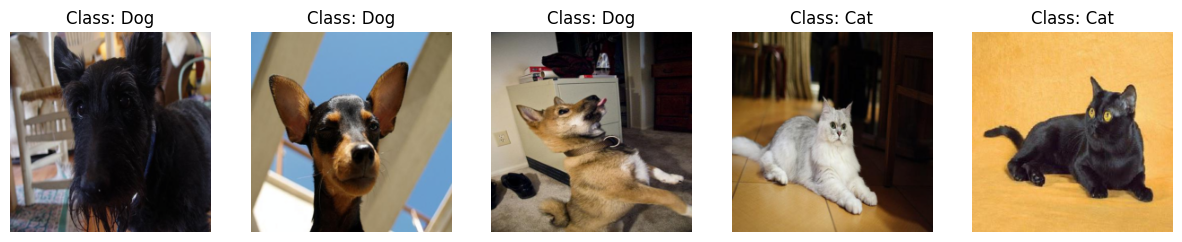

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define mean & std for denormalization (EfficientNet Preprocessing)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Display 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

imgs_indices = [270,233,110,89,15]

for i in range(5):
    img, label = train_dataset[imgs_indices[i]]  # Load image & label

    # Convert tensor to numpy for visualization
    img_np = img.numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)

    # Denormalize the image
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    # Show image
    axes[i].imshow(img_np)
    axes[i].set_title(f'Class: {"Cat" if label == 0 else "Dog"}')
    axes[i].axis('off')

plt.show()

## 2️⃣ Model Class

#### Instead of training from scratch, we use **EfficientNet-B0** with a modified output layer.


In [9]:
from torchvision import models

# Load pretrained EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Modify the classifier for binary classification (cats vs. dogs)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)  # 2 classes

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### **🔧 Why Modify the Last Layer?**

EfficientNet was trained on ImageNet (1000 classes). We only need **1 output**:
- Output > 0 → Dog (class 1)
- Output < 0 → Cat (class 0)

`BCEWithLogitsLoss` applies sigmoid internally, so we don't add it to the model.

**-:**
```
Original: [Batch, 1280] → Linear(1280, 1000) → [Batch, 1000]
Modified: [Batch, 1280] → Linear(1280, 1) → [Batch, 1]
```

## 3️⃣ Training and Validation Loops

In [10]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        
        outputs = model(images).squeeze()  # The model outputs in shape [batch_size,1]. We convert them to [batch_size,] so the loss accepts them.
        loss = criterion(outputs, labels)  

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        total_loss += loss.item()

        # Track accuracy
        predictions = torch.sigmoid(outputs) > 0.5  # Get predicted class
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).squeeze()  # The model outputs in shape [batch_size,1]. We convert them to [batch_size,] so the loss accepts them.
            loss = criterion(outputs, labels)  
            total_loss += loss.item()

            # Compute accuracy
            predictions = torch.sigmoid(outputs) > 0.5  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  
    return avg_loss, accuracy


## 4️⃣ Running Training

In [11]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Classification loss (Use when there is no softmax/sigmoid in the last layer)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, valid_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 9/9 [01:27<00:00,  9.69s/it]


Epoch 1/10: Train Loss=0.3658, Train Accuracy=82.91%, Val Loss=0.0938, Val Accuracy=95.71%


100%|██████████| 9/9 [01:22<00:00,  9.21s/it]


Epoch 2/10: Train Loss=0.0953, Train Accuracy=98.55%, Val Loss=0.1562, Val Accuracy=95.71%


100%|██████████| 9/9 [01:18<00:00,  8.69s/it]


Epoch 3/10: Train Loss=0.0410, Train Accuracy=98.55%, Val Loss=0.0870, Val Accuracy=97.14%


100%|██████████| 9/9 [01:22<00:00,  9.14s/it]


Epoch 4/10: Train Loss=0.0532, Train Accuracy=98.91%, Val Loss=0.0725, Val Accuracy=97.14%


100%|██████████| 9/9 [01:17<00:00,  8.64s/it]


Epoch 5/10: Train Loss=0.0353, Train Accuracy=98.91%, Val Loss=0.0487, Val Accuracy=97.14%


100%|██████████| 9/9 [01:19<00:00,  8.78s/it]


Epoch 6/10: Train Loss=0.0195, Train Accuracy=99.27%, Val Loss=0.0426, Val Accuracy=98.57%


100%|██████████| 9/9 [01:18<00:00,  8.72s/it]


Epoch 7/10: Train Loss=0.0121, Train Accuracy=99.27%, Val Loss=0.0690, Val Accuracy=97.14%


100%|██████████| 9/9 [01:26<00:00,  9.60s/it]


Epoch 8/10: Train Loss=0.0025, Train Accuracy=100.00%, Val Loss=0.1044, Val Accuracy=97.14%


100%|██████████| 9/9 [01:18<00:00,  8.76s/it]


Epoch 9/10: Train Loss=0.0057, Train Accuracy=100.00%, Val Loss=0.1262, Val Accuracy=95.71%


100%|██████████| 9/9 [01:21<00:00,  9.06s/it]


Epoch 10/10: Train Loss=0.0143, Train Accuracy=99.64%, Val Loss=0.1377, Val Accuracy=95.71%


### **Why `BCEWithLogitsLoss`?**
- Combines `Sigmoid + BCE Loss` in one operation (**more numerically stable**)
- Expects raw logits (no sigmoid in model needed)
- For binary classification only

**Common mistake:** Using `BCELoss` and forgetting to add `nn.Sigmoid()` in the model ❌

### Plot loss and some predictions

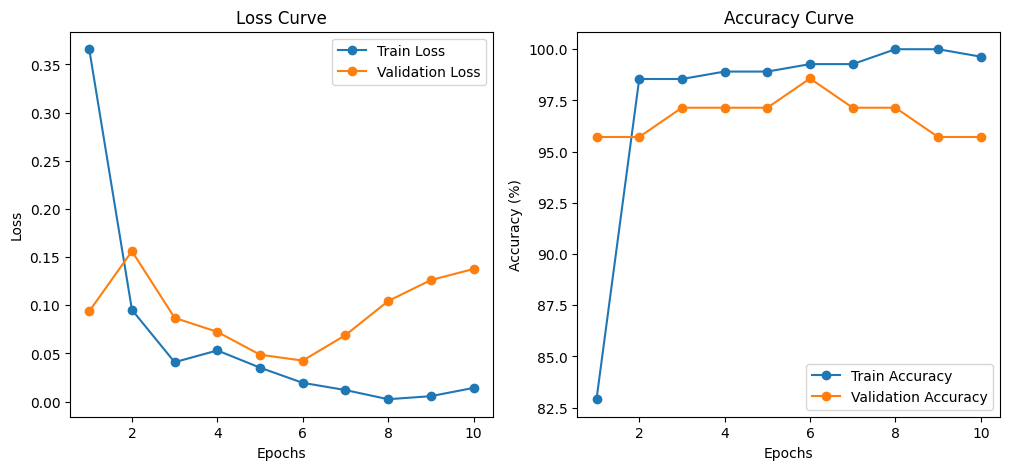

In [12]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


### **📈 Understanding the Results:**

| Observation | Meaning |
|------------|---------|
| Both losses decreasing | ✅ Model learning well |
| Val loss increasing after some epochs | ⚠️ Overfitting starting |
| Large gap between train & val accuracy | ⚠️ Need more regularization/augmentation |

**Expected results:** ~95-99% validation accuracy due to pretrained weights ✅

---

### ⚠️ Common Issues & Fixes

| Error | Cause | Solution |
|-------|-------|----------|
| `RuntimeError: expected scalar type Float` | Labels stored as int | Use `float(self.labels[idx])` in Dataset |
| `Size mismatch in BCEWithLogitsLoss` | Forgot `.squeeze()` | Add `.squeeze()` after model output |
| Low accuracy (~50%) | Forgot to use pretrained weights | Use `pretrained=True` |
| `num_workers` error on Windows | DataLoader multiprocessing issue | Set `num_workers=0` |
| Different normalization values | Not using ImageNet stats | Use `mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]` |

## **🎯 Quick Experiment (Optional)**

Try changing ONE thing and observe the impact:

1. **Remove `pretrained=True`** → See how much pretrained weights help
2. **Change `lr=0.001` to `lr=0.0001`** → Slower but more stable?
3. **Add `transforms.RandomRotation(15)`** to `transform` → Better generalization?

**Which change makes the biggest difference?**

# Very nice
Now you can detect all cats and dogs

![No cat is safe](https://i.imgur.com/1r243HR.gif)

### Contributed by: Ali Habibullah & Mohamed Eltayeb

#### Edited by: Abdulellah Mojalled